In [1]:
import pandas as pd
import numpy as np
import logging
import shared

race_type = shared.race_type()
year = shared.forecast_year()
import time
startTime = time.time()

2022-06-02 21:19:34,303 RACE_TYPE: ju
2022-06-02 21:19:34,304 FORECAST_YEAR: 2021


In [2]:
cleaned = pd.read_csv(f'Jukola-terrain/ideal-paces-{race_type}.tsv', delimiter='\t')

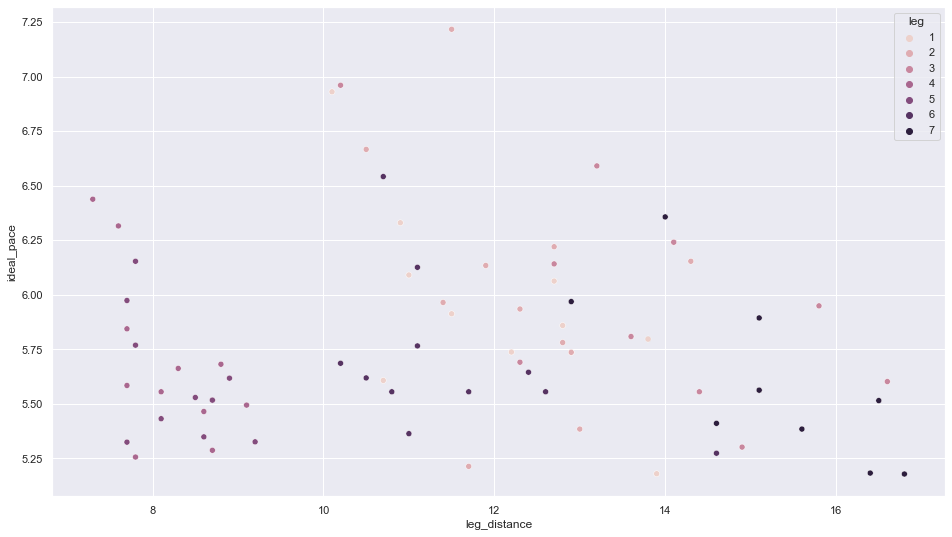

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={"figure.figsize":(16, 9)}) 
plot = sns.scatterplot(x="leg_distance", y="ideal_pace", hue="leg", data=cleaned)



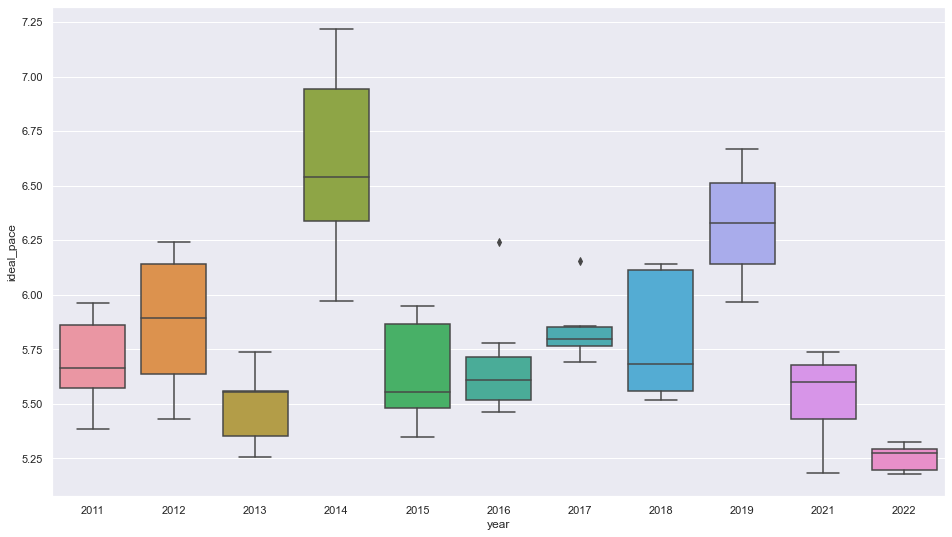

In [4]:

ax = sns.boxplot(x="year", y="ideal_pace", data=cleaned)

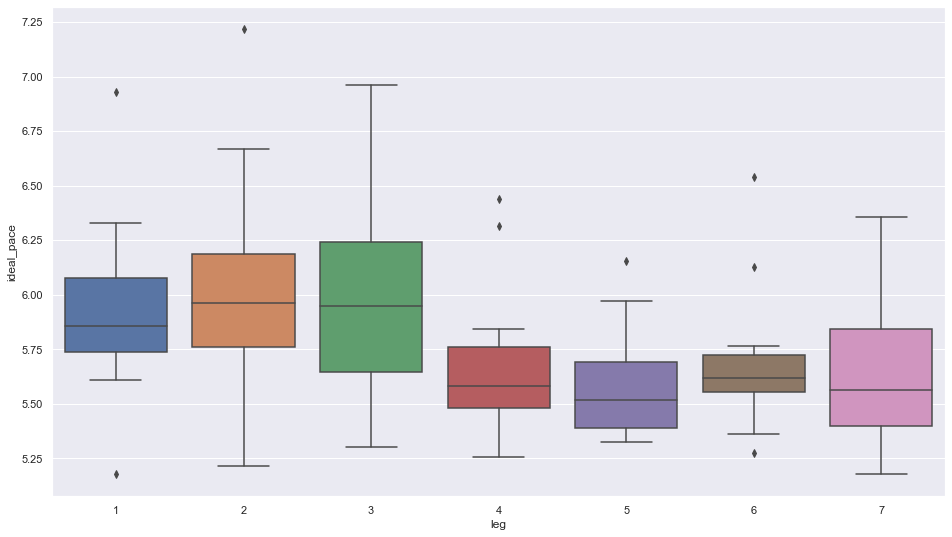

In [5]:

ax = sns.boxplot(x="leg", y="ideal_pace", data=cleaned)

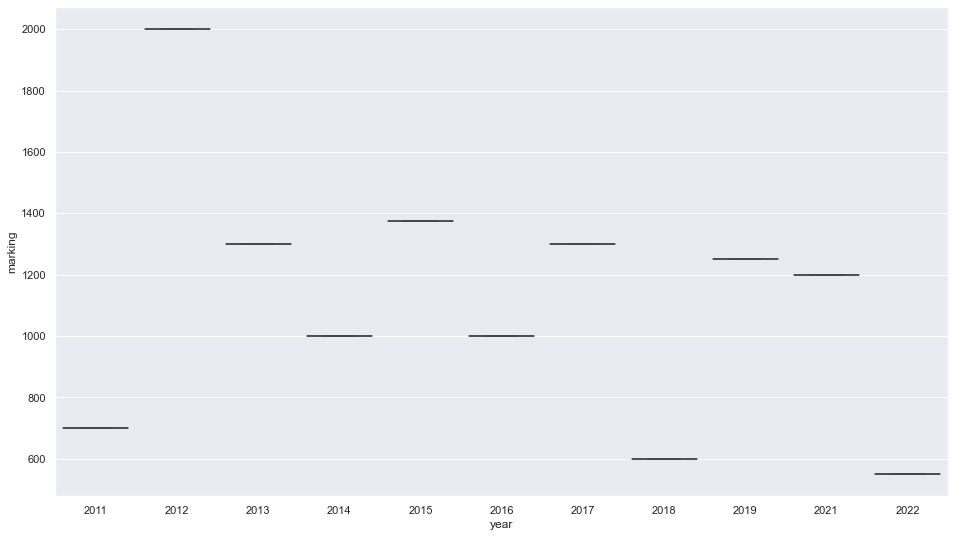

In [6]:
ax = sns.boxplot(x="year", y="marking", data=cleaned)

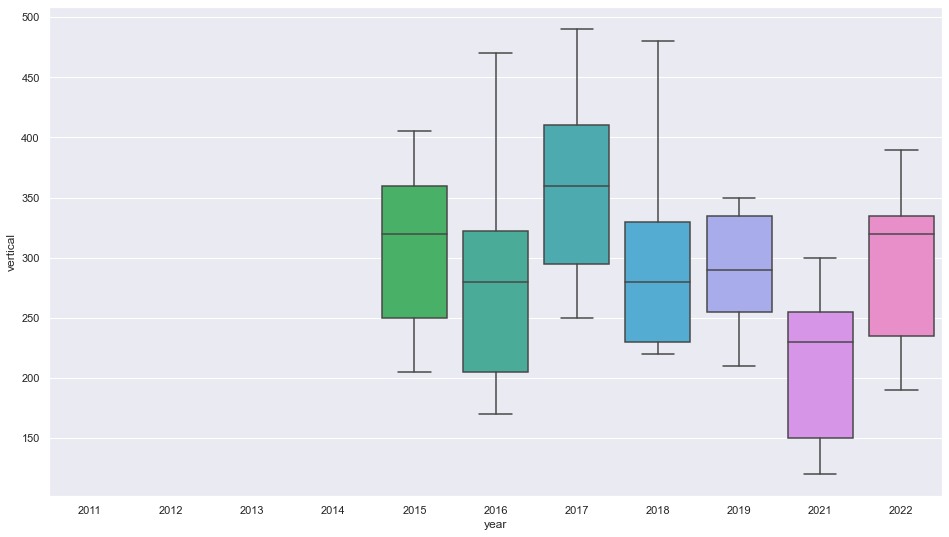

In [7]:
ax = sns.boxplot(x="year", y="vertical", data=cleaned)

In [8]:
cleaned

,year,leg,ideal_time,vertical,leg_distance,ideal_pace,marking,log_ideal_pace,leg_avg,terrain_coefficient
0,2022,1,72,320.0,13.9,5.179856,550,1.644777,1.777786,0.925183
1,2022,2,61,260.0,11.7,5.213675,550,1.651285,1.794136,0.920379
2,2022,3,79,340.0,14.9,5.302013,550,1.668087,1.790096,0.931842
3,2022,4,46,190.0,8.7,5.287356,550,1.665318,1.736692,0.958903
4,2022,5,49,210.0,9.2,5.326087,550,1.672617,1.720275,0.972296
...,...,...,...,...,...,...,...,...,...,...
72,2011,3,79,NaN,13.6,5.808824,700,1.759378,1.790096,0.982840
73,2011,4,47,NaN,8.3,5.662651,700,1.733892,1.736692,0.998388
74,2011,5,47,NaN,8.5,5.529412,700,1.710081,1.720275,0.994075
75,2011,6,59,NaN,10.5,5.619048,700,1.726162,1.738599,0.992847


In [9]:
leg_means = cleaned[["leg", "ideal_pace"]].groupby(["leg"]).agg("mean")
leg_means

,ideal_pace
leg,
1,5.931442
2,6.037152
3,6.007720
4,5.689648
5,5.591879
6,5.698973
7,5.619575


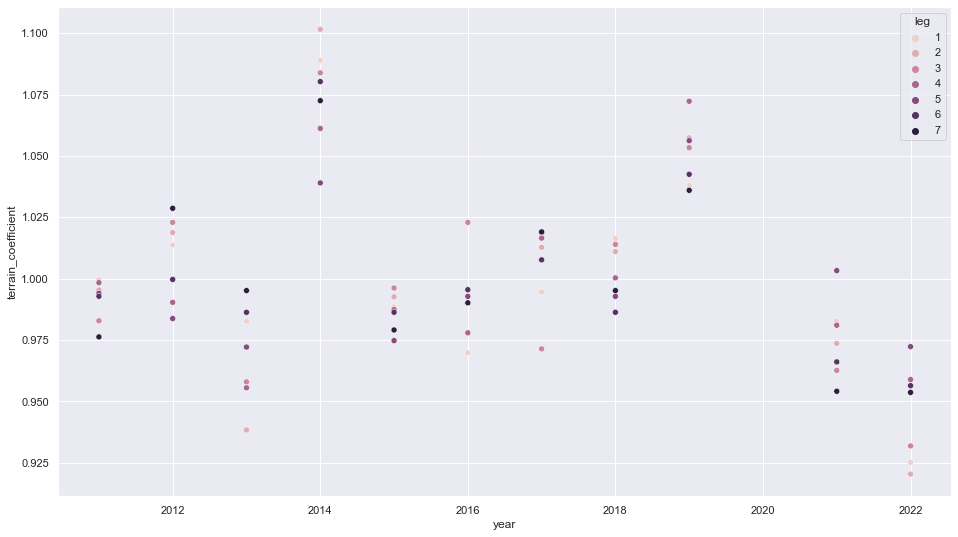

In [10]:
ax = sns.scatterplot(x="year", y="terrain_coefficient", hue="leg", data=cleaned)

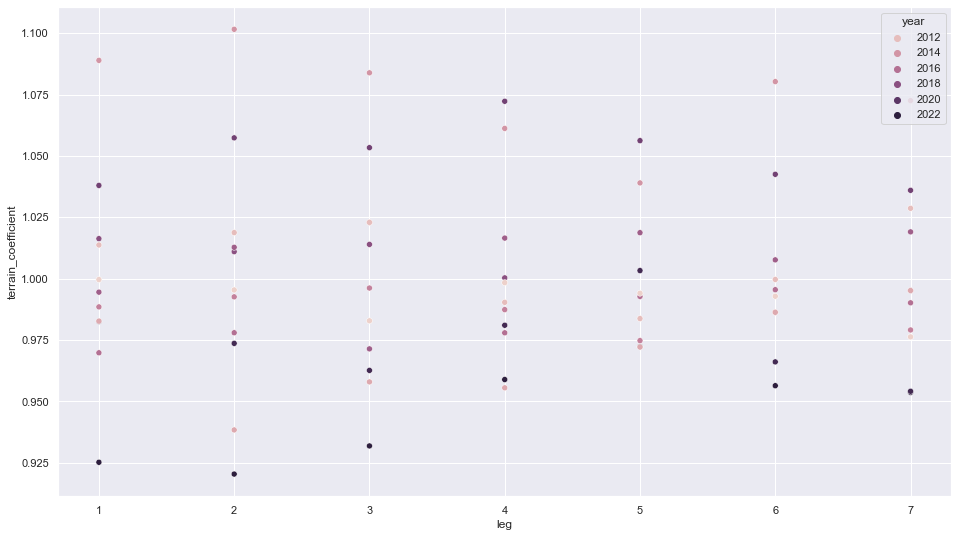

In [11]:
ax = sns.scatterplot(x="leg", y="terrain_coefficient", hue="year", data=cleaned)

In [12]:
runs = pd.read_csv(f'data/runs_{shared.race_id_str()}.tsv', delimiter='\t')
runs = runs.query("num_runs > 1")

2022-06-02 21:19:37,532 RACE_TYPE: ju
2022-06-02 21:19:37,534 FORECAST_YEAR: 2021


In [13]:
runner_means = runs[["name", "pace"]].groupby(["name"]).agg("mean")
runner_means


,pace
name,
aada forsman,10.184000
aake partio,13.796500
aale grekula,13.309667
aamos laavainen,12.947000
aapeli laitinen,9.619000
...,...
öyvind lund,7.028000
öyvind solli,8.543500
öyvind thömt,10.334200


In [14]:
runs["pace_mean"] = runner_means["pace"][runs["name"]].values
runs["personal_coefficient"] = runs["pace"] / runs["pace_mean"]

runs.head()

,name,year,team_id,team,team_country,pace,leg,num_runs,pace_mean,personal_coefficient
0,jesper svensk,2019,8,STORA TUNA OK,SWE,6.006,1,6,6.373,0.942413
1,jesper svensk,2018,162,STORA TUNA OK,SWE,6.660,2,6,6.373,1.045034
2,jesper svensk,2016,13,STORA TUNA OK,SWE,5.893,2,6,6.373,0.924682
3,jesper svensk,2015,17,STORA TUNA OK,SWE,6.425,1,6,6.373,1.008159
4,jesper svensk,2014,79,STORA TUNA OK,SWE,6.881,1,6,6.373,1.079711


In [15]:
runs = pd.merge(runs, cleaned[["year", "leg", "terrain_coefficient", "marking", "vertical"]], how="left", on=["year", "leg"])
runs["personal_terain_diff"] = runs["personal_coefficient"] - runs["terrain_coefficient"] 
runs.round(4)

,name,year,team_id,team,team_country,pace,leg,num_runs,pace_mean,personal_coefficient,terrain_coefficient,marking,vertical,personal_terain_diff
0,jesper svensk,2019,8,STORA TUNA OK,SWE,6.006,1,6,6.3730,0.9424,1.0380,1250,280.0,-0.0956
1,jesper svensk,2018,162,STORA TUNA OK,SWE,6.660,2,6,6.3730,1.0450,1.0110,600,280.0,0.0340
2,jesper svensk,2016,13,STORA TUNA OK,SWE,5.893,2,6,6.3730,0.9247,0.9780,1000,285.0,-0.0533
3,jesper svensk,2015,17,STORA TUNA OK,SWE,6.425,1,6,6.3730,1.0082,0.9885,1375,365.0,0.0196
4,jesper svensk,2014,79,STORA TUNA OK,SWE,6.881,1,6,6.3730,1.0797,1.0890,1000,NaN,-0.0093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86150,öyvind lund,2011,1156,RAUMAR OL,NOR,7.028,3,2,7.0280,1.0000,0.9828,700,NaN,0.0172
86151,laura fenyvesi:IFK MORAS OK,2011,476,IFK MORAS OK,SWE,7.918,5,2,8.6070,0.9199,0.9941,700,NaN,-0.0741
86152,laura fenyvesi:IFK MORAS OK,2011,527,IFK MORAS OK,SWE,9.296,5,2,8.6070,1.0801,0.9941,700,NaN,0.0860
86153,tormod kvärna:ÖSTMARKA OK,2011,436,ÖSTMARKA OK,NOR,7.923,3,2,10.7875,0.7345,0.9828,700,NaN,-0.2484


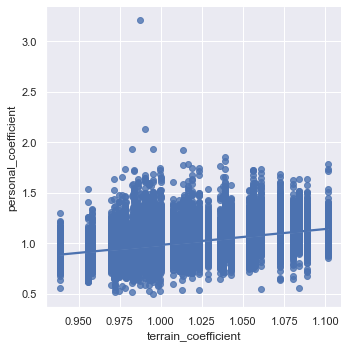

In [16]:
ax = sns.lmplot(x="terrain_coefficient", y="personal_coefficient", data=runs)

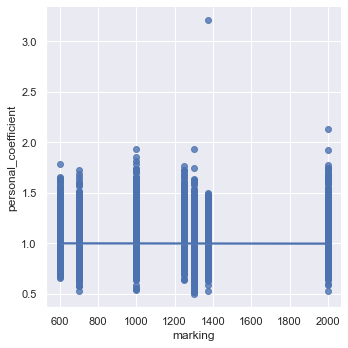

In [17]:
ax = sns.lmplot(x="marking", y="personal_coefficient", data=runs)

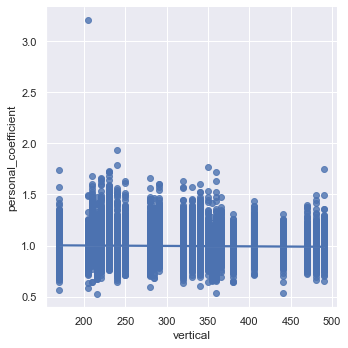

In [18]:
ax = sns.lmplot(x="vertical", y="personal_coefficient", data=runs)

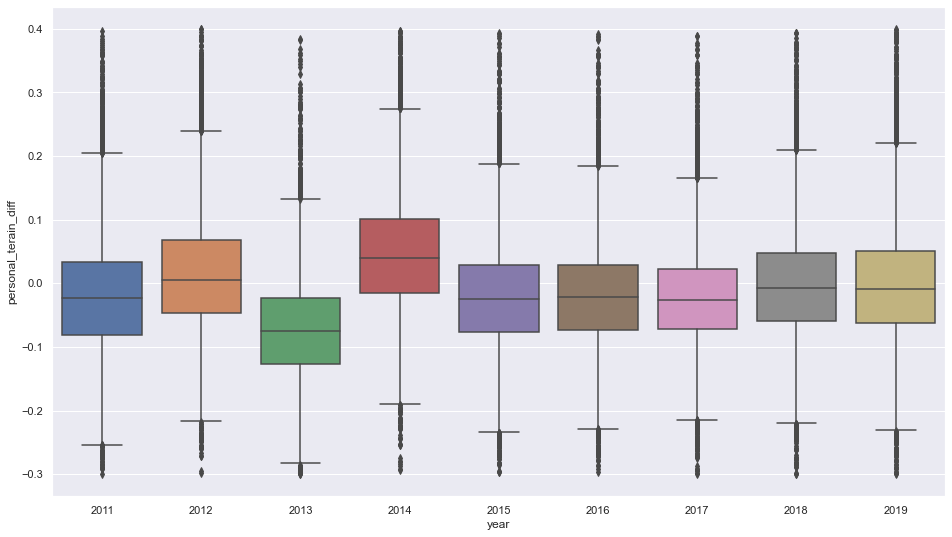

In [19]:
ax = sns.boxplot(x="year", y="personal_terain_diff", data=runs.query("personal_terain_diff < 0.4 & personal_terain_diff > -0.3 & num_runs < 10"))


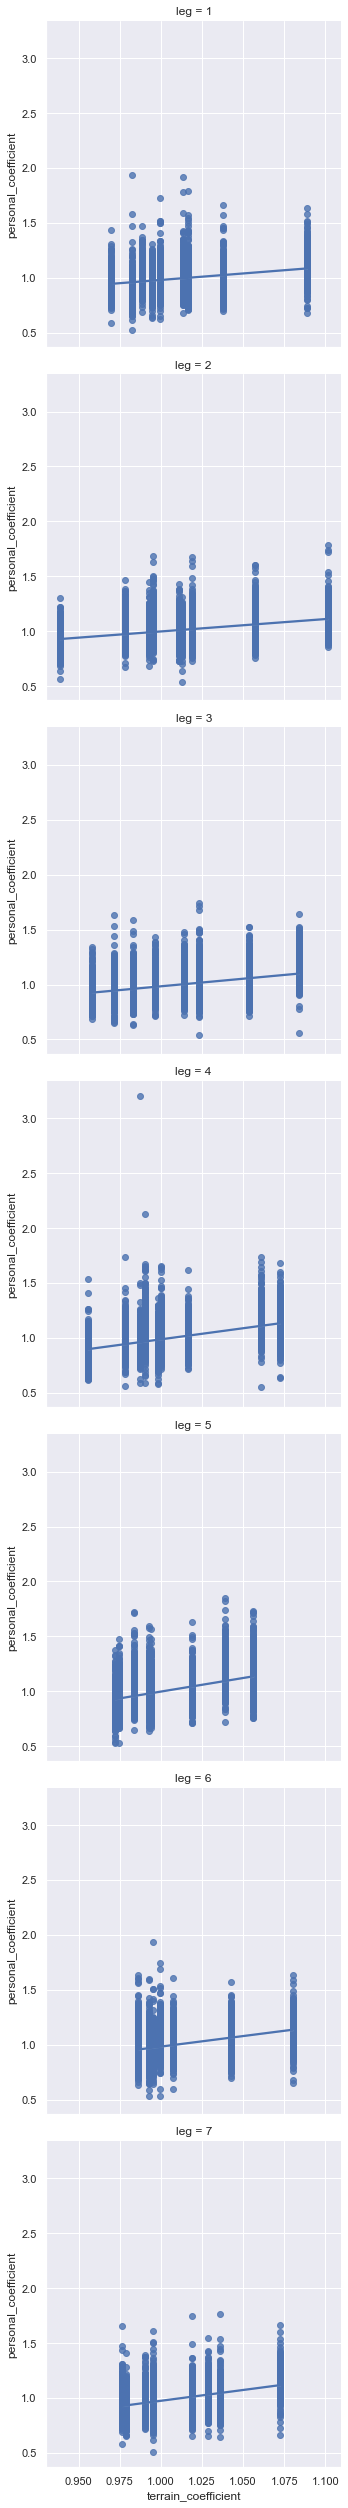

In [20]:
ax = sns.lmplot(x="terrain_coefficient", y="personal_coefficient",row="leg", data=runs)

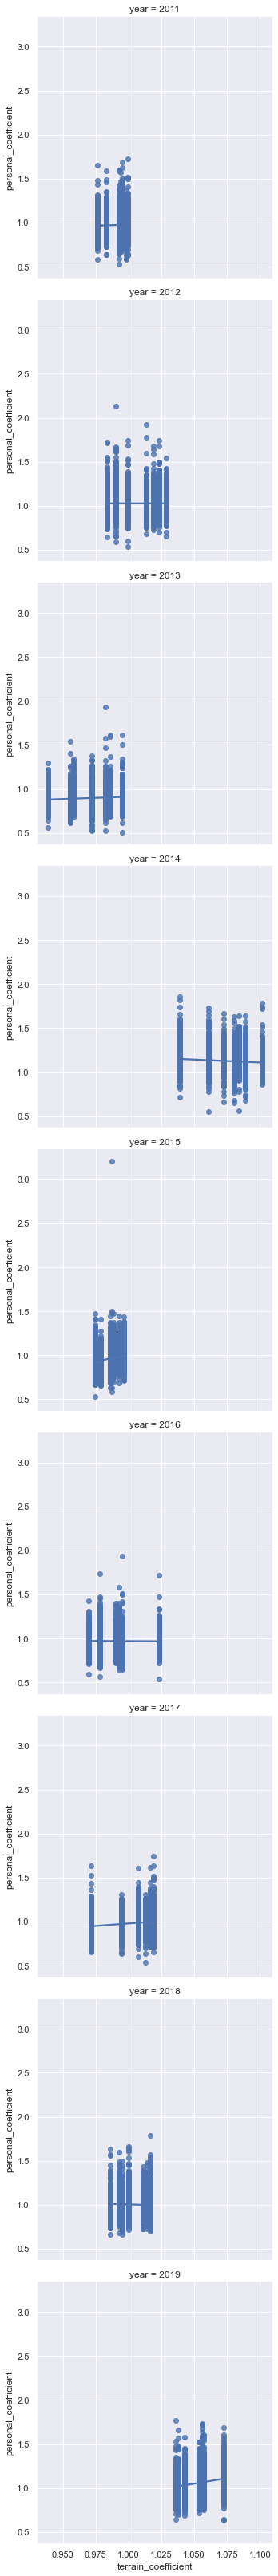

In [21]:
ax = sns.lmplot(x="terrain_coefficient", y="personal_coefficient",row="year", data=runs)

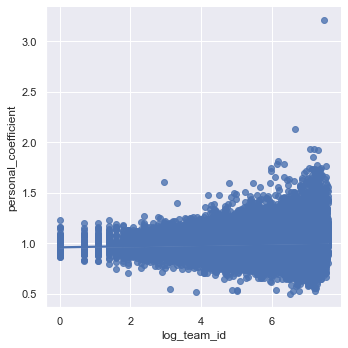

In [22]:
#
runs["log_team_id"]= np.log(runs["team_id"])
ax = sns.lmplot(x="log_team_id", y="personal_coefficient", data=runs)

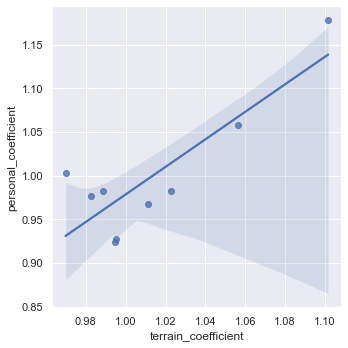

In [23]:
runner_name = "nelly carlsson"
if race_type == "ju":
    runner_name = "topi anjala"
runner = runs[runs["name"] == runner_name]
ax = sns.lmplot(x="terrain_coefficient", y="personal_coefficient",data=runner)

In [24]:
runner.round(3)

,name,year,team_id,team,team_country,pace,leg,num_runs,pace_mean,personal_coefficient,terrain_coefficient,marking,vertical,personal_terain_diff,log_team_id
318,topi anjala,2019,1,KOOVEE,FIN,6.436,5,9,6.082,1.058,1.056,1250,230.0,0.002,0.000
319,topi anjala,2018,2,KOOVEE,FIN,5.882,2,9,6.082,0.967,1.011,600,280.0,-0.044,0.693
320,topi anjala,2017,1,KOOVEE,FIN,5.621,1,9,6.082,0.924,0.995,1300,380.0,-0.070,0.000
321,topi anjala,2016,9,KOOVEE,FIN,6.100,1,9,6.082,1.003,0.970,1000,280.0,0.033,2.197
322,topi anjala,2015,12,KOOVEE,FIN,5.977,1,9,6.082,0.983,0.989,1375,365.0,-0.006,2.485
323,topi anjala,2014,21,KOOVEE,FIN,7.164,2,9,6.082,1.178,1.102,1000,NaN,0.076,3.045
324,topi anjala,2013,37,KOOVEE,FIN,5.642,7,9,6.082,0.928,0.995,1300,NaN,-0.068,3.611
325,topi anjala,2012,48,KOOVEE,FIN,5.974,3,9,6.082,0.982,1.023,2000,NaN,-0.041,3.871
326,topi anjala,2011,30,IKAALISTEN NOUSEVA-VOIMA,FIN,5.942,3,9,6.082,0.977,0.983,700,NaN,-0.006,3.401


In [25]:
runner["terrain_coefficient"].values

array([1.0562717 , 1.01102737, 0.9945198 , 0.96980247, 0.98850957,
       1.10164061, 0.9951643 , 1.02294073, 0.98284011])

In [26]:
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression


In [27]:
terrain_coefficients = runs["terrain_coefficient"]
personal_coefficients = runs["personal_coefficient"]
X = np.array(terrain_coefficients).reshape(-1, 1)
y = np.array(personal_coefficients).reshape(-1,1) 
lr = LinearRegression().fit(X, y)
defaults = {
    "default_intercept": lr.intercept_[0], 
    "default_coef": lr.coef_[0][0], 
    "score":lr.score(X, y)
}
logging.info(f"defaults: {defaults}")
import json
with open(f"data/default_personal_coefficients_{shared.race_id_str()}.json", 'w') as fp:
    json.dump(defaults, fp)

2022-06-02 21:20:06,840 defaults: {'default_intercept': -0.5828937471295952, 'default_coef': 1.568687166906974, 'score': 0.23520854482661613}
2022-06-02 21:20:06,841 RACE_TYPE: ju
2022-06-02 21:20:06,842 FORECAST_YEAR: 2021


In [28]:
X2 = np.array(runs[["terrain_coefficient", "marking"]])
X2.shape

(86155, 2)

In [29]:
lr = LinearRegression().fit(X2, y)
lr.coef_[0]

array([1.56961406e+00, 2.50282859e-06])

In [30]:
#subset = runs[runs["num_runs"] > 2]
subset = runs
#subset = runs[runs["team"] == "REAKTOR INNOVATIONS"]
by_name = pd.DataFrame(data=subset.groupby("name")["terrain_coefficient"].apply(list).items(), columns=["name", "terrain_coefficients"])    
personal = pd.DataFrame(data=subset.groupby("name")["personal_coefficient"].apply(list).items(), columns=["name", "personal_coefficients"])
by_name["personal_coefficients"] = personal["personal_coefficients"]
by_name["num_runs"] = by_name["terrain_coefficients"].apply(len)
by_name = by_name[by_name["num_runs"] > 2]
by_name

,name,terrain_coefficients,personal_coefficients,num_runs
1,aake partio,"[1.057400061279908, 1.0139718315943789, 1.0127...","[0.910883195013228, 0.7948392708295582, 0.9510...",8
2,aale grekula,"[1.0562717007461406, 1.0165546357145063, 0.992...","[1.1408249643116533, 1.0331588569711236, 0.826...",3
4,aapeli laitinen,"[1.0380012973540051, 1.0163190598076828, 1.012...","[0.9196382160307724, 0.8552864123089718, 0.918...",7
6,aapo aaltio,"[1.0534023756578297, 1.0110273652819977, 1.012...","[1.0033332801709702, 0.9110381014656864, 0.961...",9
7,aapo ala-sankila,"[1.057400061279908, 1.0163190598076828, 0.9945...","[1.0134566035711412, 1.0017077815827826, 0.958...",9
...,...,...,...,...
20240,öyvind flaatten,"[0.9901639341688472, 0.9791037817859412, 0.982...","[1.0367274569402227, 0.9164133738601824, 1.002...",4
20241,öyvind helgerud,"[1.0425420316013965, 1.0003336366884799, 1.012...","[0.999795272366494, 1.223310603316588, 0.97910...",9
20244,öyvind johannessen,"[1.0110273652819977, 0.9713982169998714, 1.022...","[1.0492939716800913, 0.9670520117375976, 1.047...",6
20247,öyvind thömt,"[1.0425420316013965, 1.0110273652819977, 0.971...","[1.0679104333184959, 0.9817886241799076, 0.933...",5


In [31]:
def calculate_coef(row):
    name = row["name"]
    terrain_coefficients = row["terrain_coefficients"]
    X = np.array(terrain_coefficients).reshape(len(terrain_coefficients),1) 
    y = np.array(row["personal_coefficients"]).reshape(len(terrain_coefficients),1) 
    lr = LinearRegression().fit(X, y)
    score = lr.score(X, y)
    #logging.info(f"{name} intercept_: {lr.intercept_}, coef_: {lr.coef_[0][0]}")
    return [lr.coef_[0][0], lr.intercept_[0],  score]

by_name[["coef", "intercept", "score"]] = by_name.apply(calculate_coef, axis=1, result_type="expand")  
by_name.sample(10).round(4)

,name,terrain_coefficients,personal_coefficients,num_runs,coef,intercept,score
20178,yannick michiels,"[1.0380012973540051, 1.0190766876637336, 0.969...","[0.9123204837490552, 0.9652305366591081, 0.954...",5,2.5367,-1.5852,0.5711
4772,henry lågland,"[1.0725548443626725, 0.9863104535584069, 0.994...","[1.1823979591836735, 0.9189761131725419, 0.898...",3,3.2825,-2.3405,0.9789
17992,timo kinnunen,"[1.0889726321389763, 0.9951642961501236, 0.982...","[1.157770460551969, 0.8074823447857544, 1.0347...",3,2.1328,-1.1804,0.4853
14145,paul gebbett,"[0.9951642961501236, 0.9945198029665508, 0.990...","[1.0380407507778782, 0.9335541503563183, 0.848...",5,16.6102,-15.5041,0.4107
17886,timi jaarinen,"[1.057400061279908, 1.0110273652819977, 1.0803...","[1.086361107544828, 0.9400008559079043, 1.1251...",5,2.1288,-1.1734,0.8010
16813,simon dahlberg,"[0.9863104535584069, 1.007672219930815, 0.9747...","[1.0373365977353213, 1.1090805753508504, 0.853...",3,7.2129,-6.1378,0.8347
13322,ola hultin,"[0.9863104535584069, 0.9779428566122996, 0.974...","[0.9853319275659876, 1.0689750846234947, 0.961...",7,2.9022,-1.8792,0.6327
2891,eivind tonna,"[0.9779746289752688, 0.9791037817859412, 0.957...","[1.0115723337987326, 0.9790838792825689, 0.990...",5,0.6219,0.3853,0.3951
9821,konsta puranen,"[1.0534023756578297, 1.0139718315943789, 0.971...","[1.0591805766312594, 0.9324044695820113, 0.888...",6,2.4583,-1.5138,0.9110
13717,osku kiviniemi,"[1.0534023756578297, 1.0003336366884799, 0.971...","[1.0524654709080683, 1.075245297168927, 0.9914...",9,1.7503,-0.7574,0.7016


In [32]:
by_name["bad_prediction"] = (by_name["coef"] <= 0) | (by_name["score"] <= 0)
by_name["bad_prediction"].mean()

0.12801618263256756

In [33]:
by_name[['bad_prediction', "num_runs", "score"]].groupby(['num_runs']).agg(["mean", "count"])

bad_prediction           score      
                   mean count      mean count
num_runs                                     
3              0.256357  3343  0.583647  3343
4              0.179245  2544  0.476855  2544
5              0.113859  1941  0.456095  1941
6              0.067756  1653  0.436915  1653
7              0.032656  1623  0.443418  1623
8              0.033438  1585  0.418651  1585
9              0.017422  1148  0.427812  1148
10             0.000000     3  0.398150     3
11             0.000000     1  0.004010     1
13             0.000000     1  0.577410     1

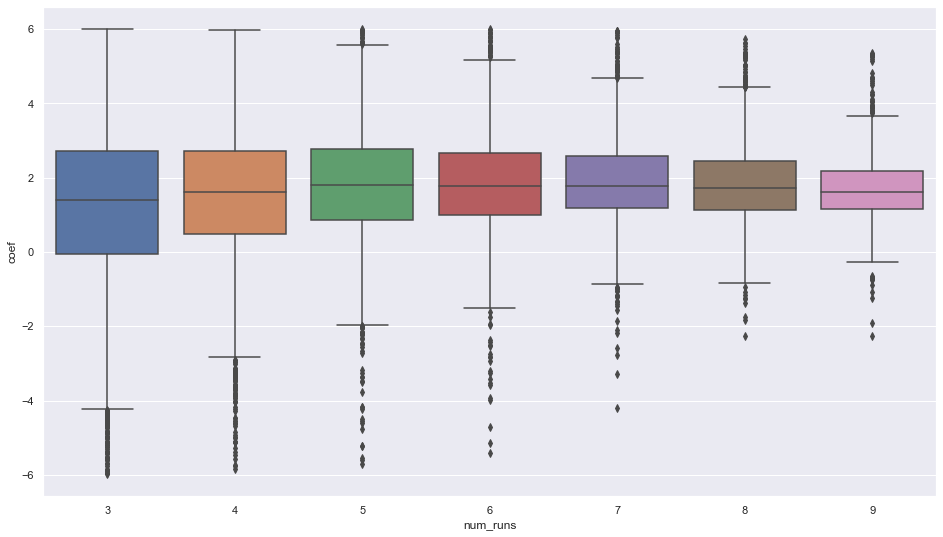

In [34]:
ax = sns.boxplot(x="num_runs", y="coef", data=by_name.query("coef < 6 & coef > -6 & num_runs <= 9 "))

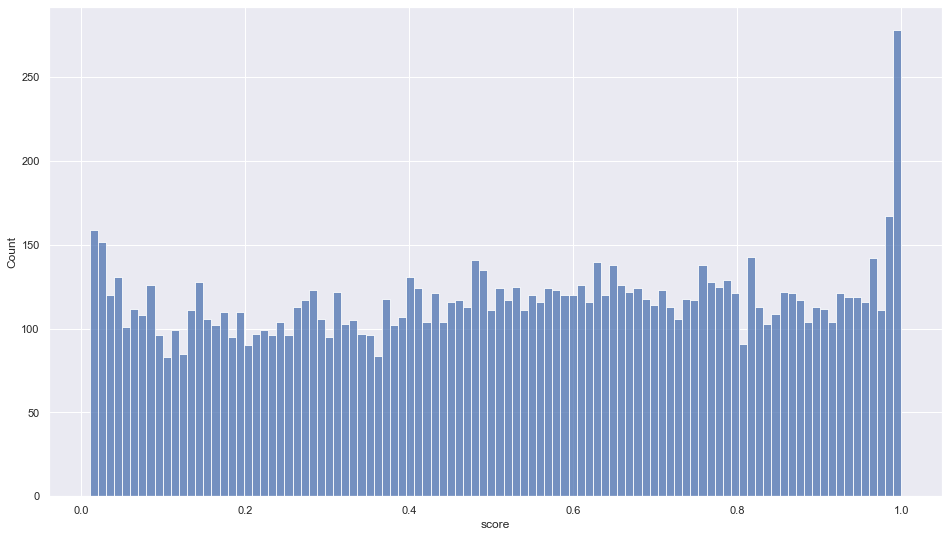

In [35]:
ax = sns.histplot(data=by_name.query("coef > 0 & score > 0.01"), x="score", bins=100)

In [36]:
by_name.query("coef > 0 & score > 0.99").sort_values(by=['num_runs'], ascending=False)

,name,terrain_coefficients,personal_coefficients,num_runs,coef,intercept,score,bad_prediction
1351,antti pendikainen,"[0.9951642961501236, 0.9779428566122996, 1.101...","[0.9941967867738987, 0.9375454833834039, 1.196...",6,2.024931,-1.034145,0.993441,False
709,andreas nikolausson,"[1.0360211516632667, 0.9951642961501236, 0.977...","[1.0617507806991036, 0.948171653067392, 0.9246...",5,2.300312,-1.330937,0.990106,False
16252,samu pylvänäinen,"[1.0723106940488285, 0.9863104535584069, 0.986...","[1.3171263405804152, 0.8727640773108588, 0.874...",5,5.203868,-4.268081,0.998399,False
8933,jörgen tegdan,"[1.0229407274721756, 0.9926001924836824, 1.061...","[1.0395933367311356, 0.933903806432576, 1.1523...",5,3.212830,-2.248330,0.993876,False
5728,janne joensivu,"[1.0425420316013965, 0.9863104535584069, 1.019...","[1.080014205321532, 0.9587226137791619, 1.0272...",5,2.164046,-1.177393,0.994973,False
...,...,...,...,...,...,...,...,...
998,anton bordyukov,"[0.9901639341688472, 0.974774193476138, 1.0725...","[0.9304580256421873, 0.8913151814433924, 1.178...",3,2.958532,-1.995507,0.999569,False
8286,jukka matilainen:KYMIN SUUNNISTAJAT,"[1.1016406138011283, 1.0187886579222911, 0.982...","[1.1594206113304644, 0.9535291247060912, 0.887...",3,2.326240,-1.406316,0.996008,False
8440,julius hakkarainen,"[1.0110273652819977, 0.9945198029665508, 0.987...","[1.0827996815396863, 0.9783308525736438, 0.938...",3,6.131912,-5.117483,0.999112,False
8450,juri haverinen,"[0.9951642961501236, 0.982716550201272, 1.0229...","[0.9924081103601518, 0.9480603647810386, 1.059...",3,2.711896,-1.712639,0.990202,False


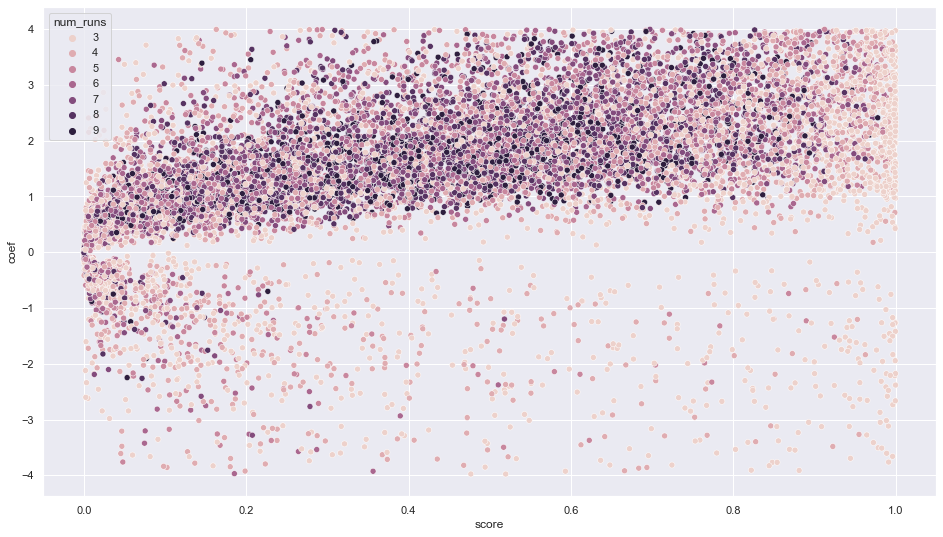

In [37]:
ax = sns.scatterplot(x="score", y="coef", hue="num_runs", data=by_name.query("coef < 4 & coef > -4 & num_runs < 10"))

In [38]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'p_%s' % n
    return percentile_

leg_stats = runs[['year', "leg", "pace"]].groupby(['year', "leg"]).agg(
        ["min",percentile(1) ,percentile(5) ,"median", "mean", "std", "count"])

In [39]:
leg_stats = leg_stats.reset_index()
leg_stats.columns = [f"{pair[0]}{pair[1]}" for pair in leg_stats.columns] 
leg_stats

,year,leg,pacemin,pacep_1,pacep_5,pacemedian,pacemean,pacestd,pacecount
0,2011,1,6.068,6.14200,6.46985,9.1625,9.392616,2.307224,1280
1,2011,2,6.016,6.38000,6.90100,10.1370,10.641679,2.904620,1261
2,2011,3,5.608,6.19840,6.71430,9.1020,9.500243,2.471150,1263
3,2011,4,5.257,5.77570,6.37345,9.9750,10.298125,2.914002,1148
4,2011,5,5.263,5.50626,6.17920,10.2590,10.546836,3.099620,1084
...,...,...,...,...,...,...,...,...,...
58,2019,3,5.576,6.07883,6.93020,9.8735,10.260622,2.578480,1570
59,2019,4,6.041,6.77781,7.73690,12.2580,13.008146,4.304844,1340
60,2019,5,5.895,6.47528,7.19060,12.5150,12.991121,4.242319,1223
61,2019,6,5.321,6.05820,6.98650,10.9620,11.109272,2.684877,1271


In [40]:
with_runs = pd.merge(cleaned, leg_stats, how="left", on=["year", "leg"])
with_runs

,year,leg,ideal_time,vertical,leg_distance,ideal_pace,marking,log_ideal_pace,leg_avg,terrain_coefficient,pacemin,pacep_1,pacep_5,pacemedian,pacemean,pacestd,pacecount
0,2022,1,72,320.0,13.9,5.179856,550,1.644777,1.777786,0.925183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022,2,61,260.0,11.7,5.213675,550,1.651285,1.794136,0.920379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022,3,79,340.0,14.9,5.302013,550,1.668087,1.790096,0.931842,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022,4,46,190.0,8.7,5.287356,550,1.665318,1.736692,0.958903,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022,5,49,210.0,9.2,5.326087,550,1.672617,1.720275,0.972296,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,2011,3,79,NaN,13.6,5.808824,700,1.759378,1.790096,0.982840,5.608,6.19840,6.71430,9.102,9.500243,2.471150,1263.0
73,2011,4,47,NaN,8.3,5.662651,700,1.733892,1.736692,0.998388,5.257,5.77570,6.37345,9.975,10.298125,2.914002,1148.0
74,2011,5,47,NaN,8.5,5.529412,700,1.710081,1.720275,0.994075,5.263,5.50626,6.17920,10.259,10.546836,3.099620,1084.0
75,2011,6,59,NaN,10.5,5.619048,700,1.726162,1.738599,0.992847,5.024,5.42263,6.16695,9.496,9.571350,2.397945,1104.0


In [41]:
with_ideal = pd.merge(runs, cleaned, how="left", on=["year", "leg"])
with_ideal["ideal_ratio"] = with_ideal["pace"] / with_ideal["ideal_pace"]
with_ideal

,name,year,team_id,team,team_country,pace,leg,num_runs,pace_mean,personal_coefficient,...,log_team_id,ideal_time,vertical_y,leg_distance,ideal_pace,marking_y,log_ideal_pace,leg_avg,terrain_coefficient_y,ideal_ratio
0,jesper svensk,2019,8,STORA TUNA OK,SWE,6.006,1,6,6.3730,0.942413,...,2.079442,69,280.0,10.9,6.330275,1250,1.845344,1.777786,1.038001,0.948774
1,jesper svensk,2018,162,STORA TUNA OK,SWE,6.660,2,6,6.3730,1.045034,...,5.087596,73,280.0,11.9,6.134454,600,1.813921,1.794136,1.011027,1.085671
2,jesper svensk,2016,13,STORA TUNA OK,SWE,5.893,2,6,6.3730,0.924682,...,2.564949,74,285.0,12.8,5.781250,1000,1.754620,1.794136,0.977975,1.019330
3,jesper svensk,2015,17,STORA TUNA OK,SWE,6.425,1,6,6.3730,1.008159,...,2.833213,80,365.0,13.8,5.797101,1375,1.757358,1.777786,0.988510,1.108313
4,jesper svensk,2014,79,STORA TUNA OK,SWE,6.881,1,6,6.3730,1.079711,...,4.369448,70,NaN,10.1,6.930693,1000,1.935960,1.777786,1.088973,0.992830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86150,öyvind lund,2011,1156,RAUMAR OL,NOR,7.028,3,2,7.0280,1.000000,...,7.052721,79,NaN,13.6,5.808824,700,1.759378,1.790096,0.982840,1.209884
86151,laura fenyvesi:IFK MORAS OK,2011,476,IFK MORAS OK,SWE,7.918,5,2,8.6070,0.919949,...,6.165418,47,NaN,8.5,5.529412,700,1.710081,1.720275,0.994075,1.431979
86152,laura fenyvesi:IFK MORAS OK,2011,527,IFK MORAS OK,SWE,9.296,5,2,8.6070,1.080051,...,6.267201,47,NaN,8.5,5.529412,700,1.710081,1.720275,0.994075,1.681191
86153,tormod kvärna:ÖSTMARKA OK,2011,436,ÖSTMARKA OK,NOR,7.923,3,2,10.7875,0.734461,...,6.077642,79,NaN,13.6,5.808824,700,1.759378,1.790096,0.982840,1.363959


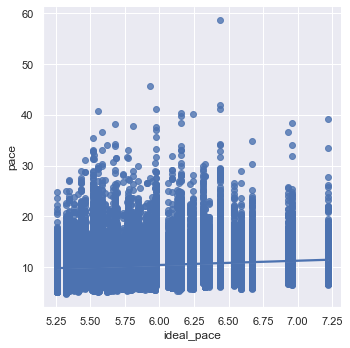

In [42]:
with_ideal.columns
ax = sns.lmplot(x="ideal_pace", y="pace", data=with_ideal)

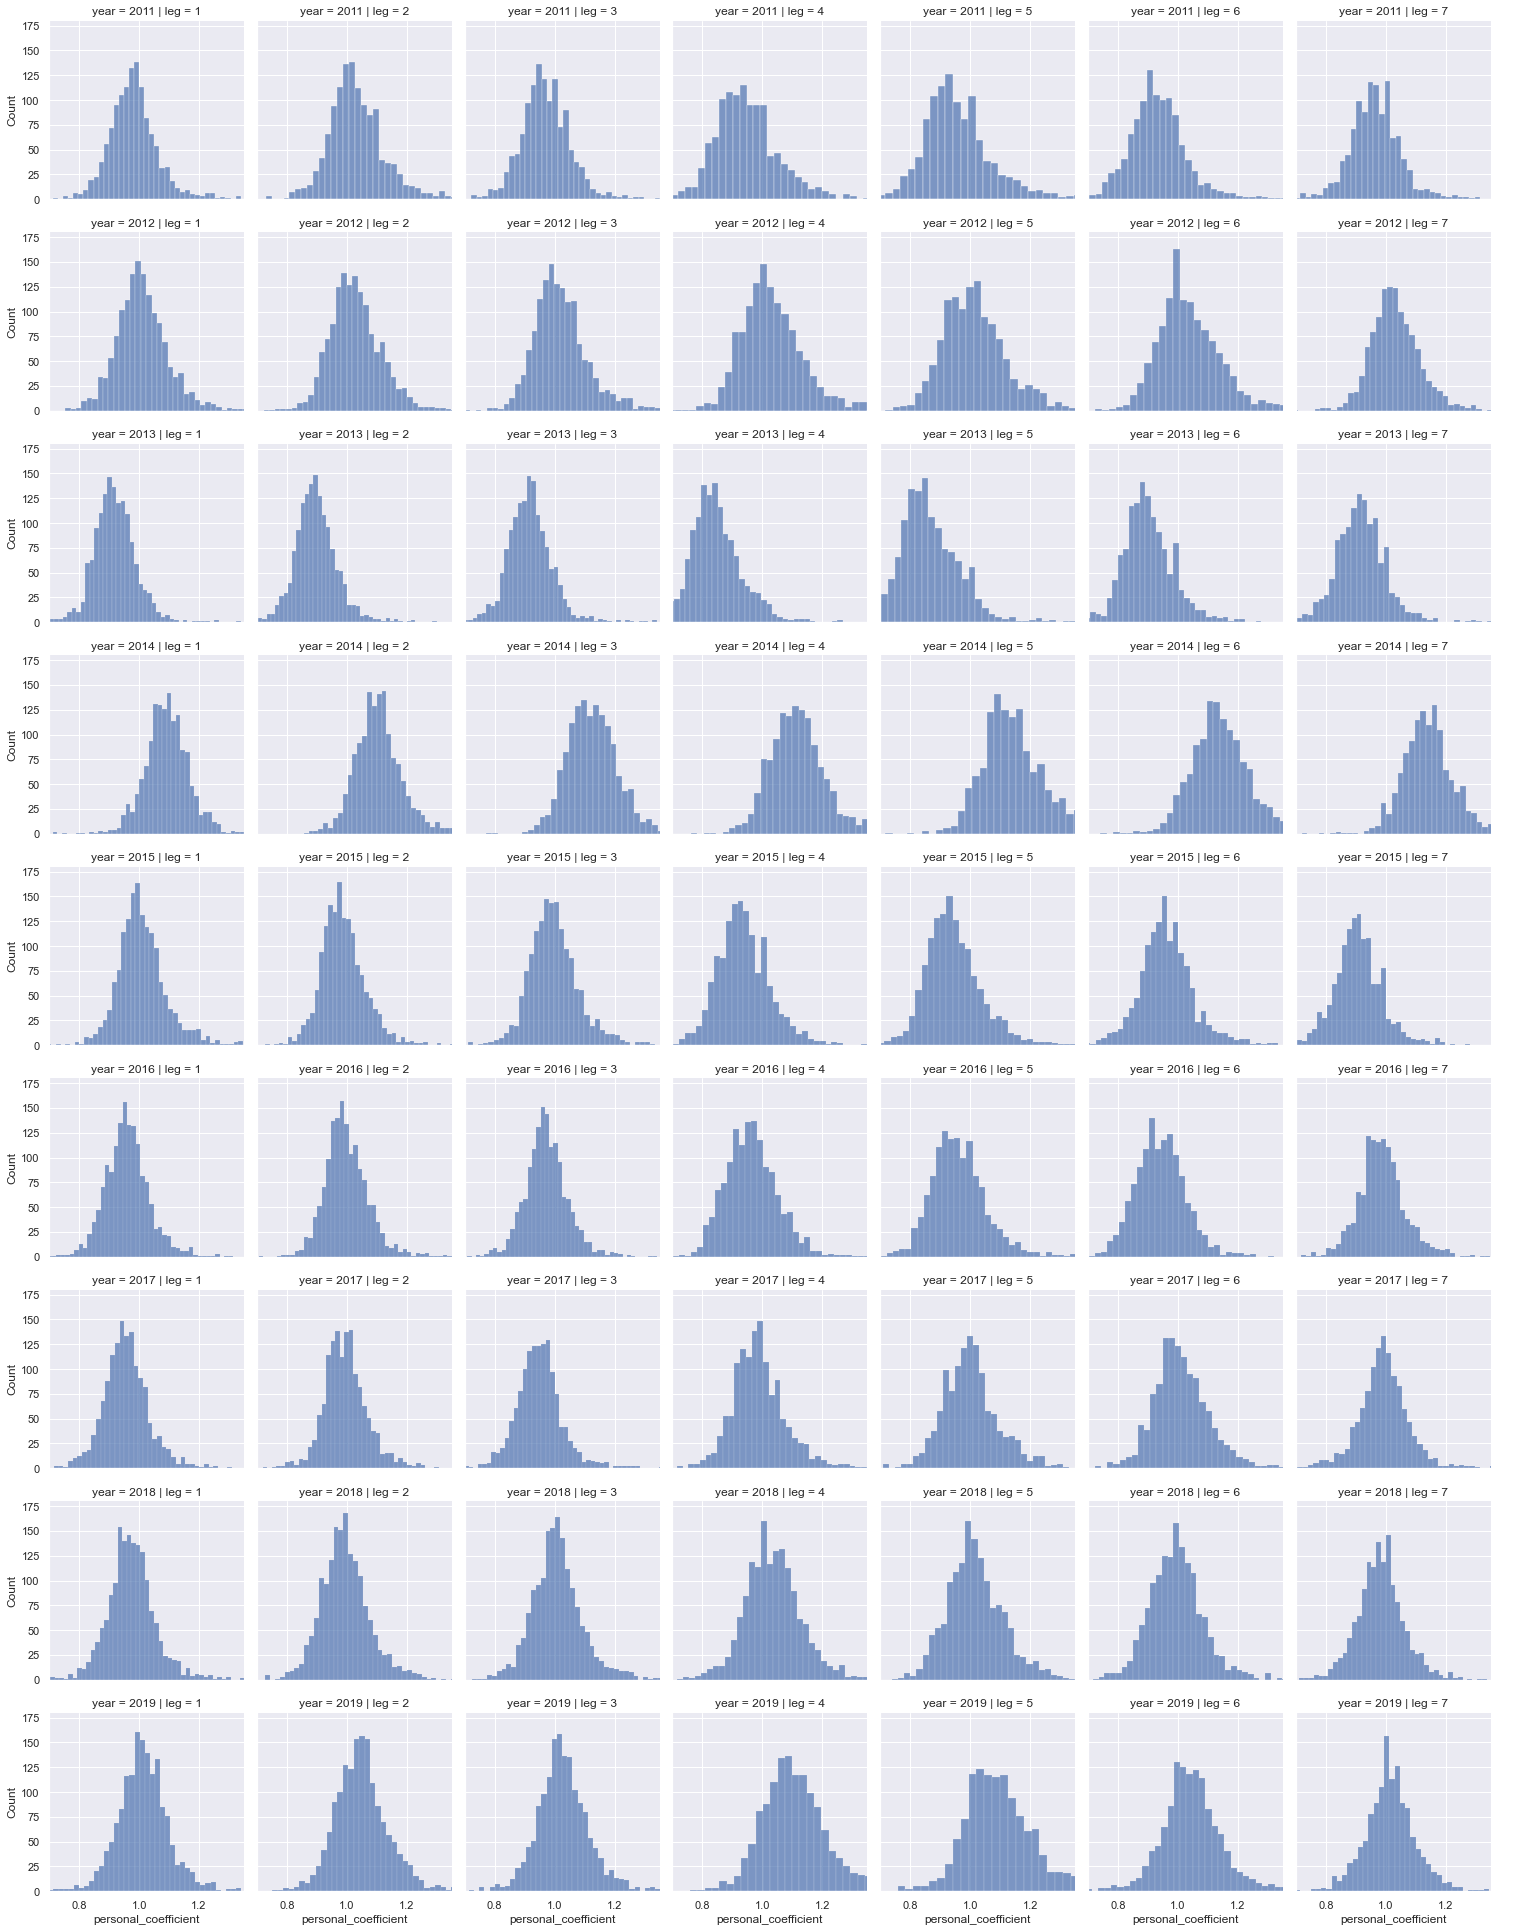

In [43]:
g = sns.FacetGrid(with_ideal, col="leg", row="year")
g.map(sns.histplot, "personal_coefficient", alpha=.7)
g.add_legend()
g.set(xlim=(0.7, 1.35), ylim=(0, 180))
plt.axvline(2.8, 0,0.17)